# Predicting Survey Star Ratings 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
from pandas.io import sql
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
host="cms.ctvgwsug2thu.us-west-1.rds.amazonaws.com"
port=3306
dbname="cms"
user="bassrocker400"
password="}7n^:EU6DJs:iWN__3Ku"

conn = pymysql.connect(host, user=user,port=port,
                           passwd=password, db=dbname)

In [12]:
survey = pd.read_sql('''
select h.`Provider ID`,h.`year`, h.`HCAHPS Measure ID`, 
case when h.`Patient Survey Star Rating` = "Not Applicable" and h.`HCAHPS Answer Percent` = "Not Applicable" then h.`HCAHPS Linear Mean Value`
when h.`HCAHPS Answer Percent` = "Not Applicable" and h.`HCAHPS Linear Mean Value` = "Not Applicable" then h.`Patient Survey Star Rating`
when h.`Patient Survey Star Rating` = "Not Applicable" and h.`HCAHPS Linear Mean Value` = "Not Applicable" then h.`HCAHPS Answer Percent`
else Null end as Score 
from hospital_survey h
join (
select `Provider ID`, year from hospital_survey
where `HCAHPS Question` = "Summary star rating" 
and `Patient Survey Star Rating` <> "Not Available") a on h.`Provider ID` = a.`Provider ID` and h.year = a.`year`
''', con = conn)

In [13]:
survey.head()

,Provider ID,year,HCAHPS Measure ID,Score
0,010001,2018,H_STAR_RATING,2
1,010001,2018,H_CLEAN_HSP_A_P,66
2,010001,2018,H_CLEAN_HSP_SN_P,12
3,010001,2018,H_CLEAN_HSP_U_P,22
4,010001,2018,H_CLEAN_LINEAR_SCORE,84


In [14]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752030 entries, 0 to 752029
Data columns (total 4 columns):
Provider ID          752030 non-null object
year                 752030 non-null int64
HCAHPS Measure ID    752030 non-null object
Score                752030 non-null object
dtypes: int64(1), object(3)
memory usage: 23.0+ MB


In [15]:
survey['Score'] = survey['Score'].astype(float)

In [16]:
survey = pd.pivot_table(survey, values = 'Score', index = ['Provider ID', 'year'], columns = 'HCAHPS Measure ID').reset_index()

In [17]:
survey.head()

HCAHPS Measure ID,Provider ID,year,H_CLEAN_HSP_A_P,H_CLEAN_HSP_SN_P,H_CLEAN_HSP_U_P,H_CLEAN_LINEAR_SCORE,H_CLEAN_STAR_RATING,H_COMP_1_A_P,H_COMP_1_LINEAR_SCORE,H_COMP_1_SN_P,...,H_QUIET_HSP_SN_P,H_QUIET_HSP_U_P,H_QUIET_LINEAR_SCORE,H_QUIET_STAR_RATING,H_RECMND_DN,H_RECMND_DY,H_RECMND_LINEAR_SCORE,H_RECMND_PY,H_RECMND_STAR_RATING,H_STAR_RATING
0,010001,2015,66.0,12.0,22.0,84.0,2.0,75.0,89.0,7.0,...,6.0,28.0,87.0,4.0,4.0,76.0,90.0,20.0,4.0,3.0
1,010001,2016,65.0,12.0,23.0,84.0,2.0,76.0,90.0,6.0,...,6.0,25.0,88.0,4.0,5.0,74.0,89.0,21.0,3.0,3.0
2,010001,2017,67.0,12.0,21.0,84.0,2.0,76.0,89.0,7.0,...,5.0,27.0,87.0,4.0,6.0,72.0,88.0,22.0,3.0,3.0
3,010001,2018,66.0,12.0,22.0,84.0,2.0,74.0,88.0,8.0,...,7.0,30.0,85.0,3.0,6.0,69.0,87.0,25.0,3.0,2.0
4,010005,2015,71.0,9.0,20.0,87.0,3.0,82.0,93.0,3.0,...,7.0,22.0,88.0,4.0,3.0,76.0,91.0,21.0,4.0,4.0


In [18]:
survey.columns

Index(['Provider ID', 'year', 'H_CLEAN_HSP_A_P', 'H_CLEAN_HSP_SN_P',
       'H_CLEAN_HSP_U_P', 'H_CLEAN_LINEAR_SCORE', 'H_CLEAN_STAR_RATING',
       'H_COMP_1_A_P', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_1_SN_P',
       'H_COMP_1_STAR_RATING', 'H_COMP_1_U_P', 'H_COMP_2_A_P',
       'H_COMP_2_LINEAR_SCORE', 'H_COMP_2_SN_P', 'H_COMP_2_STAR_RATING',
       'H_COMP_2_U_P', 'H_COMP_3_A_P', 'H_COMP_3_LINEAR_SCORE',
       'H_COMP_3_SN_P', 'H_COMP_3_STAR_RATING', 'H_COMP_3_U_P', 'H_COMP_4_A_P',
       'H_COMP_4_LINEAR_SCORE', 'H_COMP_4_SN_P', 'H_COMP_4_STAR_RATING',
       'H_COMP_4_U_P', 'H_COMP_5_A_P', 'H_COMP_5_LINEAR_SCORE',
       'H_COMP_5_SN_P', 'H_COMP_5_STAR_RATING', 'H_COMP_5_U_P',
       'H_COMP_6_LINEAR_SCORE', 'H_COMP_6_N_P', 'H_COMP_6_STAR_RATING',
       'H_COMP_6_Y_P', 'H_COMP_7_A', 'H_COMP_7_D_SD', 'H_COMP_7_LINEAR_SCORE',
       'H_COMP_7_SA', 'H_COMP_7_STAR_RATING', 'H_HSP_RATING_0_6',
       'H_HSP_RATING_7_8', 'H_HSP_RATING_9_10', 'H_HSP_RATING_LINEAR_SCORE',
       'H_HSP_RATI

In [26]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13988 entries, 0 to 13987
Data columns (total 57 columns):
Provider ID                  13988 non-null object
year                         13988 non-null int64
H_CLEAN_HSP_A_P              13988 non-null float64
H_CLEAN_HSP_SN_P             13988 non-null float64
H_CLEAN_HSP_U_P              13988 non-null float64
H_CLEAN_LINEAR_SCORE         13988 non-null float64
H_CLEAN_STAR_RATING          13988 non-null float64
H_COMP_1_A_P                 13988 non-null float64
H_COMP_1_LINEAR_SCORE        13988 non-null float64
H_COMP_1_SN_P                13988 non-null float64
H_COMP_1_STAR_RATING         13988 non-null float64
H_COMP_1_U_P                 13988 non-null float64
H_COMP_2_A_P                 13988 non-null float64
H_COMP_2_LINEAR_SCORE        13988 non-null float64
H_COMP_2_SN_P                13988 non-null float64
H_COMP_2_STAR_RATING         13988 non-null float64
H_COMP_2_U_P                 13988 non-null float64
H_COMP_3_A

In [27]:
survey.dropna(inplace = True)

In [28]:
logreg = LogisticRegression()
ss = StandardScaler()
X = survey[['H_CLEAN_HSP_A_P', 'H_CLEAN_HSP_SN_P',
       'H_CLEAN_HSP_U_P', 'H_CLEAN_LINEAR_SCORE', 'H_CLEAN_STAR_RATING',
       'H_COMP_1_A_P', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_1_SN_P',
       'H_COMP_1_STAR_RATING', 'H_COMP_1_U_P', 'H_COMP_2_A_P',
       'H_COMP_2_LINEAR_SCORE', 'H_COMP_2_SN_P', 'H_COMP_2_STAR_RATING',
       'H_COMP_2_U_P', 'H_COMP_3_A_P', 'H_COMP_3_LINEAR_SCORE',
       'H_COMP_3_SN_P', 'H_COMP_3_STAR_RATING', 'H_COMP_3_U_P', 'H_COMP_4_A_P',
       'H_COMP_4_LINEAR_SCORE', 'H_COMP_4_SN_P', 'H_COMP_4_STAR_RATING',
       'H_COMP_4_U_P', 'H_COMP_5_A_P', 'H_COMP_5_LINEAR_SCORE',
       'H_COMP_5_SN_P', 'H_COMP_5_STAR_RATING', 'H_COMP_5_U_P',
       'H_COMP_6_LINEAR_SCORE', 'H_COMP_6_N_P', 'H_COMP_6_STAR_RATING',
       'H_COMP_6_Y_P', 'H_COMP_7_A', 'H_COMP_7_D_SD', 'H_COMP_7_LINEAR_SCORE',
       'H_COMP_7_SA', 'H_COMP_7_STAR_RATING', 'H_HSP_RATING_0_6',
       'H_HSP_RATING_7_8', 'H_HSP_RATING_9_10', 'H_HSP_RATING_LINEAR_SCORE',
       'H_HSP_RATING_STAR_RATING', 'H_QUIET_HSP_A_P', 'H_QUIET_HSP_SN_P',
       'H_QUIET_HSP_U_P', 'H_QUIET_LINEAR_SCORE', 'H_QUIET_STAR_RATING',
       'H_RECMND_DN', 'H_RECMND_DY', 'H_RECMND_LINEAR_SCORE', 'H_RECMND_PY',
       'H_RECMND_STAR_RATING']]
y = survey['H_STAR_RATING']

X_train, X_test, y_train, y_test = train_test_split(X,y)

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

model = logreg.fit(X_train_scaled, y_train)




In [29]:
print("Train: ",model.score(X_train_scaled, y_train))
print("Test: ", model.score(X_test_scaled, y_test))
      


Train:  0.8769951862173803
Test:  0.8514437689969605


Text(0.5, 1.0, 'Logistic Regression Coefficients')

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


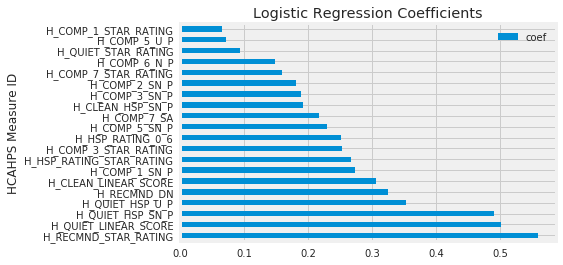

In [30]:
coefs = pd.DataFrame(logreg.coef_[0], index = X.columns, columns = ['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head(20).plot(kind = 'barh')
plt.title('Logistic Regression Coefficients')

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators= 300)
rf.fit(X_train_scaled,y_train)

print("Train: ", rf.score(X_train_scaled, y_train))
print("Test: ", rf.score(X_test_scaled, y_test))


Train:  1.0
Test:  0.9297112462006079
